## Google Drive Preprocessing (eseguire una volta sola)

In [ ]:
# Preprocessing
import pandas as pd

# List to hold all DataFrame objects
data_frames = []

# Load each CSV file into a DataFrame and append to the list
for i in range(1, 34):
    file_path = train+'Sample'+str(i)+'.csv'
    df = pd.read_csv(file_path)
    data_frames.append(df)

# Concatenate all DataFrames along rows (axis=0)
combined_data = pd.concat(data_frames, axis=0, ignore_index=True)
combined_data.sort_values(by='time', inplace=True)

# Save the combined DataFrame to a new CSV file
combined_data.to_csv(train+'combined_data.csv', index=False)


In [ ]:
# Preprocessing Test set

# List to hold all DataFrame objects
data_frames = []

# Load each CSV file into a DataFrame and append to the list
for i in range(35, 44):
    file_path = test+'Sample'+str(i)+'.csv'
    df = pd.read_csv(file_path)
    data_frames.append(df)

# Concatenate all DataFrames along rows (axis=0)
combined_data = pd.concat(data_frames, axis=0, ignore_index=True)
combined_data.sort_values(by='time', inplace=True)

# Save the combined DataFrame to a new CSV file
combined_data.to_csv(test+'combined_data.csv', index=False)


# Env preparation

In [54]:
# Google Drive mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [55]:
# Path of train and test samples
root = 'drive/MyDrive/DroneDataset/'
train = 'drive/MyDrive/DroneDataset/TrainSet/'
test = 'drive/MyDrive/DroneDataset/TestSet/'

# Import and split Dataset

In [116]:
import pandas as pd

# Load train data
file_path = train+'Sample1.csv'
df = pd.read_csv(file_path)

print(df.columns)

Index(['time', 'xF', 'yF', 'zF', 'xFdot', 'yFdot', 'zFdot', 'p', 'q', 'r',
       'phi', 'theta', 'psi', 'Omega1', 'Omega2', 'Omega3', 'Omega4'],
      dtype='object')


In [117]:
# Split the data into features and targets
X = df.iloc[:, 1:13]  # Features (first 12 columns)
y = df.iloc[:, 13:]  # Targets (last 4 columns)

print(X.columns)
print(y.columns)

Index(['xF', 'yF', 'zF', 'xFdot', 'yFdot', 'zFdot', 'p', 'q', 'r', 'phi',
       'theta', 'psi'],
      dtype='object')
Index(['Omega1', 'Omega2', 'Omega3', 'Omega4'], dtype='object')


In [118]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(48000, 12)
(12001, 12)
(48000, 4)
(12001, 4)


# Scaling

In [119]:
from sklearn.preprocessing import MinMaxScaler

# Faccio lo scaling solo delle features (le Omega rimangono normali)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

In [61]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(48000, 12)
(12001, 12)


In [120]:
columns = ['xF', 'yF', 'zF', 'xFdot', 'yFdot', 'zFdot', 'p', 'q', 'r', 'phi','theta', 'psi']
df_X_test_scaled = pd.DataFrame(X_test_scaled,columns=columns)
df_X_test_scaled.shape

(12001, 12)

# Explore Dataset

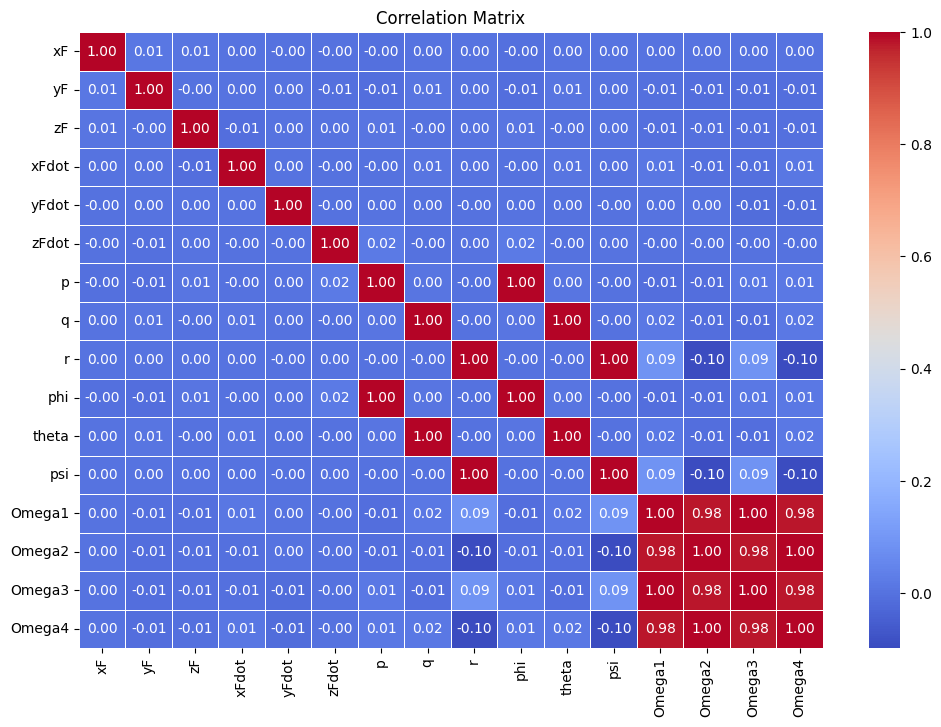

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


# Train GRU Neural Network

In [121]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras import layers, models

import seaborn as sns
import matplotlib.pyplot as plt

In [122]:
# Reshape data for input to GRU (batch_size, time_steps, features)
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [123]:
model = models.Sequential([
    layers.GRU(64, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    layers.Dense(32, activation='relu'),
    layers.Dense(4)  # Output layer with 4 neurons for Omega1, Omega2, Omega3, Omega4
])

In [124]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [125]:
# Define callbacks
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

In [126]:
time_steps = 1

GRU = models.Sequential([
    layers.GRU(64, activation='relu', input_shape=(time_steps, X_train_reshaped.shape[2])),
    layers.Dense(32, activation='relu'),
    layers.Dense(4)  # Output layer with 4 neurons for Omega1, Omega2, Omega3, Omega4
])

# Compile the model
GRU.compile(optimizer='adam', loss='mse')  # Use mean squared error for regression

# Train the model
history = GRU.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1,callbacks=[early_stopping_callback])

Epoch 1/50
1200/1200 [==============================] - 14s 6ms/step - loss: 12373.5459 - val_loss: 264.6036
Epoch 2/50
1200/1200 [==============================] - 6s 5ms/step - loss: 114.9731 - val_loss: 15.8089
Epoch 3/50
1200/1200 [==============================] - 4s 4ms/step - loss: 5.4961 - val_loss: 0.1753
Epoch 4/50
1200/1200 [==============================] - 3s 3ms/step - loss: 2.6389 - val_loss: 0.0683
Epoch 5/50
1200/1200 [==============================] - 4s 4ms/step - loss: 2.6427 - val_loss: 0.0422
Epoch 6/50
1200/1200 [==============================] - 5s 4ms/step - loss: 2.6593 - val_loss: 0.0328
Epoch 7/50
1200/1200 [==============================] - 4s 3ms/step - loss: 2.6946 - val_loss: 0.0290
Epoch 8/50
1200/1200 [==============================] - 4s 3ms/step - loss: 2.7548 - val_loss: 0.0287
Epoch 9/50
1200/1200 [==============================] - 4s 4ms/step - loss: 2.6958 - val_loss: 0.0258
Epoch 10/50
1200/1200 [==============================] - 5s 4ms/step - l

In [127]:
# Evaluate the model on the test set
y_pred_GRU = GRU.predict(X_test_reshaped)

376/376 [==============================] - 1s 2ms/step


In [128]:
columns_pred = ['Omega1','Omega2','Omega3','Omega4']
df_y_pred_GRU = pd.DataFrame(y_pred_GRU,columns=columns_pred)

# Linear Regression

In [129]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_variable(dataframe,variable):

  # Plot with time on the x-axis and Omega1 on the y-axis
  plt.plot(df['time'].iloc[-12001:],dataframe[variable] , marker='o', linestyle='-', color='b')

  # Add labels and title
  plt.xlabel('Time')
  plt.ylabel(variable)

  # Rotate y-axis labels to be vertical
  plt.xticks(rotation='vertical')

  # Show the plot
  plt.show()


In [ ]:
plot_variable(df_X_test_scaled,'xF')
plot_variable(df_X_test_scaled,'yF')
plot_variable(df_X_test_scaled,'zF')
plot_variable(df_X_test_scaled,'xFdot')
plot_variable(df_X_test_scaled,'yFdot')
plot_variable(df_X_test_scaled,'zFdot')
plot_variable(df_X_test_scaled,'p')
plot_variable(df_X_test_scaled,'q')
plot_variable(df_X_test_scaled,'r')
plot_variable(df_X_test_scaled,'phi')
plot_variable(df_X_test_scaled,'theta')
plot_variable(df_X_test_scaled,'psi')

In [130]:
from sklearn.linear_model import LinearRegression


# Initialize the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train_scaled, y_train)

LinearRegression()

In [131]:
# Make predictions on the test set
y_pred_LR = model.predict(X_test_scaled)

In [133]:
columns_pred = ['Omega1','Omega2','Omega3','Omega4']
df_y_pred_LR = pd.DataFrame(y_pred,columns=columns_pred)

# Metrics

In [134]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

mse_GRU = mean_squared_error(y_test, y_pred_GRU)
mse_LR = mean_squared_error(y_test, y_pred_LR)

mae_GRU = mean_absolute_error(y_test, y_pred_GRU)
mae_LR = mean_absolute_error(y_test, y_pred_LR)

r2_GRU = r2_score(y_test, y_pred_GRU)
r2_LR = r2_score(y_test,y_pred_LR)

print(f'GRU Network:')
print(f'MSE: {mse_GRU}')
print(f'MAE: {mae_GRU}')
print(f'R2 score: {r2_GRU}')

print()

print('Linear Regression:')
print(f'MSE: {mse_LR}')
print(f'MAE: {mae_LR}')
print(f'R2 score: {r2_LR}')

GRU Network:
MSE: 0.02051623564467366
MAE: 0.10138813459868914
R2 score: -0.3806382702661213

Linear Regression:
MSE: 0.0006712705960361898
MAE: 0.020640452852391543
R2 score: 0.9548311113008605


# Plotting

In [102]:
def plot_targets(df_test,df_predicted,variable):
  plt.figure(figsize=(12, 6))  # Adjust width as needed

  # Plot two columns
  plt.plot(df['time'], df_test[variable], label='Actual', marker='o', linestyle='-', color='b')
  plt.plot(df['time'], df_predicted[variable], label='Predicted', marker='o', linestyle='-', color='r')

  # Add labels and title
  plt.xlabel('Time')
  plt.ylabel(variable)
  plt.title(variable)
  plt.legend()  # Show legend

  # Show the plot
  plt.show()

GRU predictions


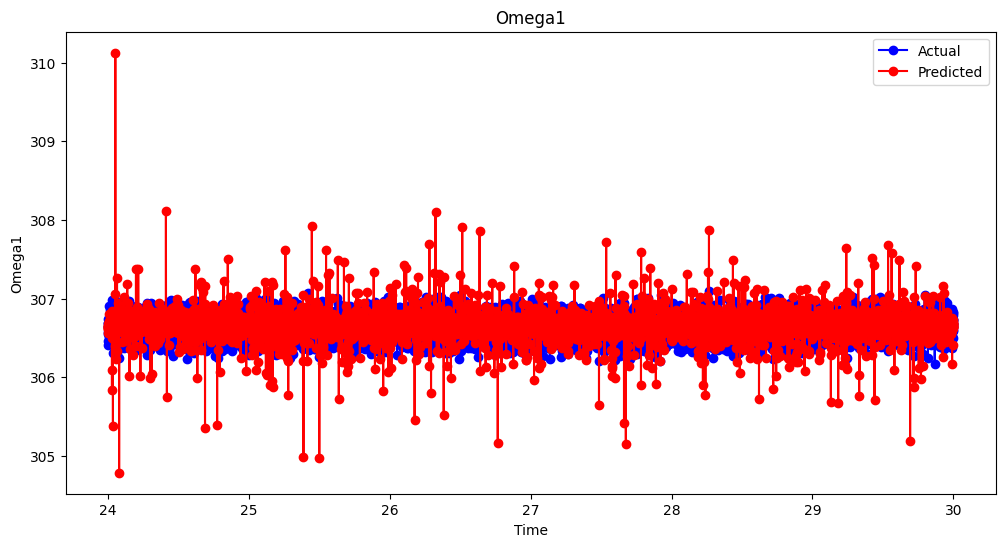


Linear Regression predictions


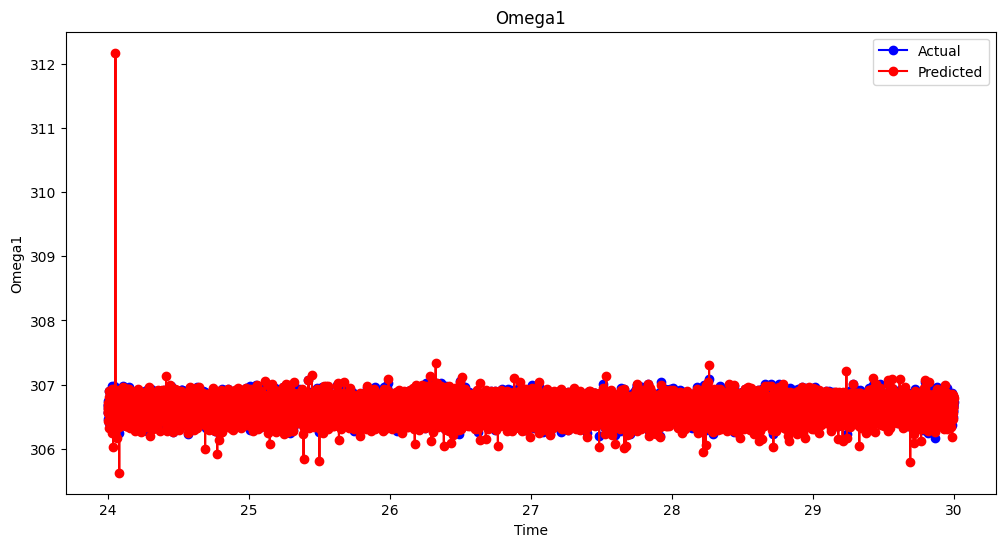

In [137]:
print('GRU predictions')
plot_targets(y_test,df_y_pred_GRU,'Omega1')

print()

print('Linear Regression predictions')
plot_targets(y_test,df_y_pred_LR,'Omega1')

GRU predictions


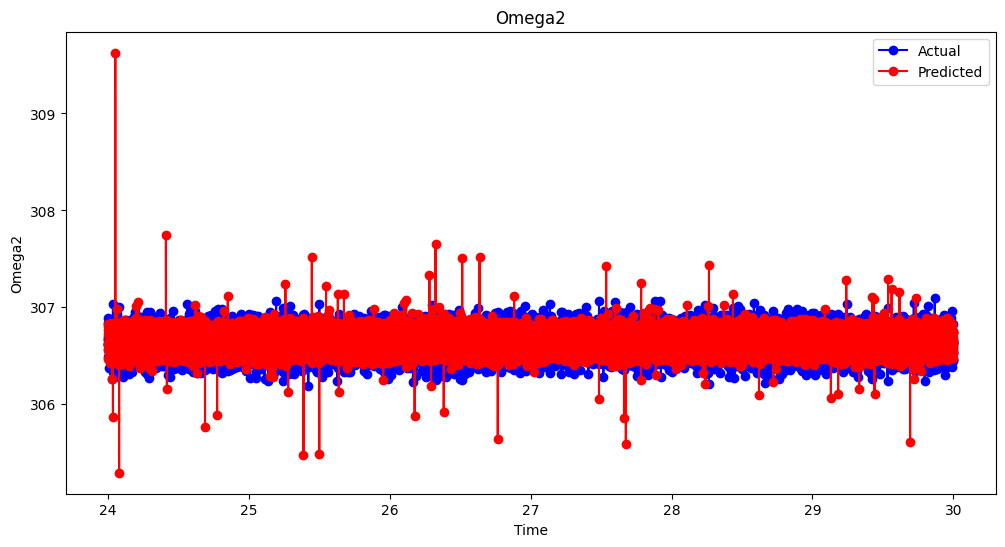


Linear Regression predictions


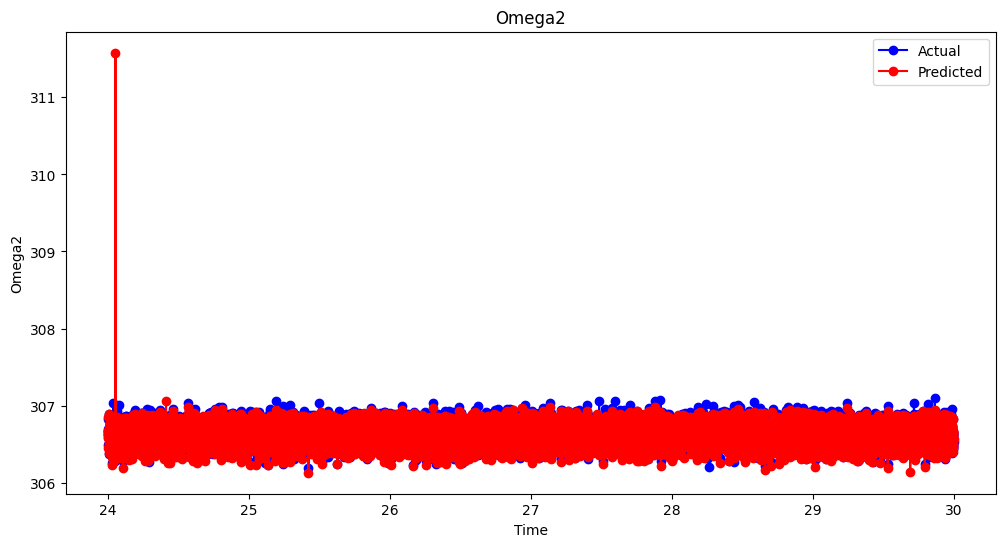

In [138]:
print('GRU predictions')
plot_targets(y_test,df_y_pred_GRU,'Omega2')

print()

print('Linear Regression predictions')
plot_targets(y_test,df_y_pred_LR,'Omega2')

GRU predictions


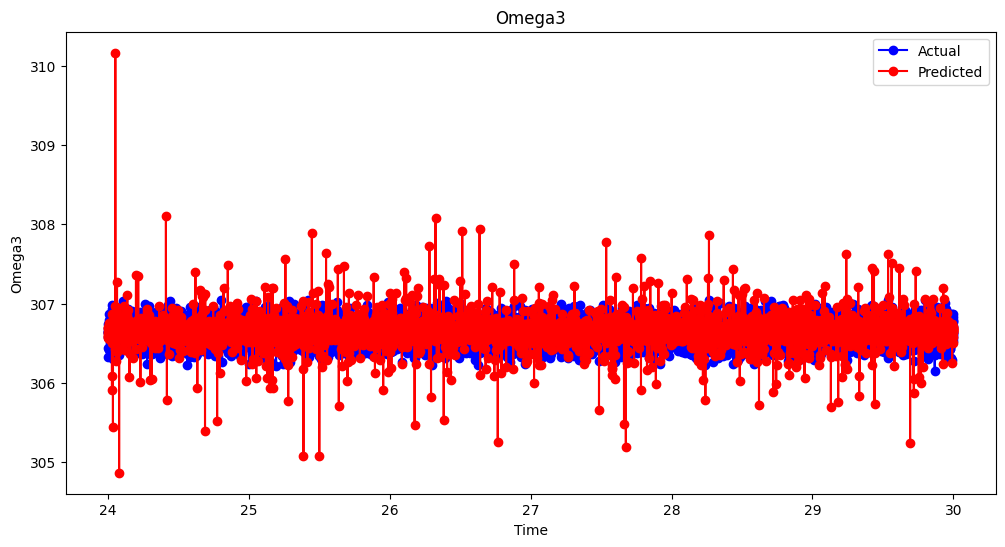


Linear Regression predictions


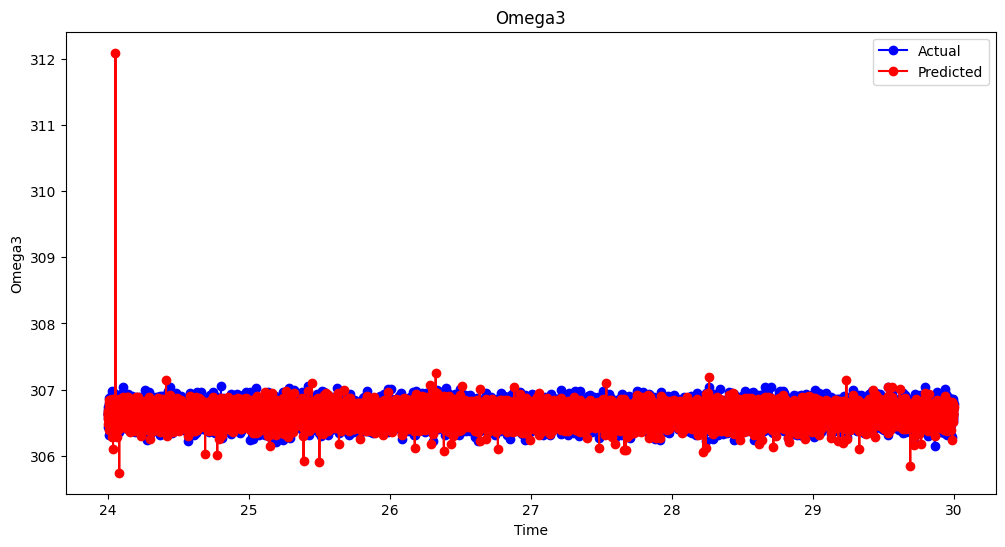

In [139]:
print('GRU predictions')
plot_targets(y_test,df_y_pred_GRU,'Omega3')

print()

print('Linear Regression predictions')
plot_targets(y_test,df_y_pred_LR,'Omega3')

GRU predictions


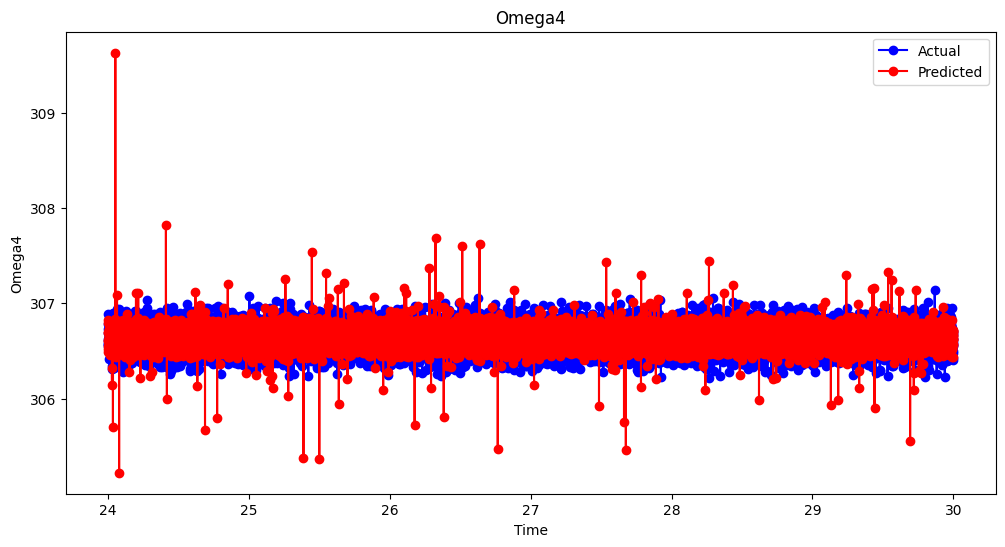


Linear Regression predictions


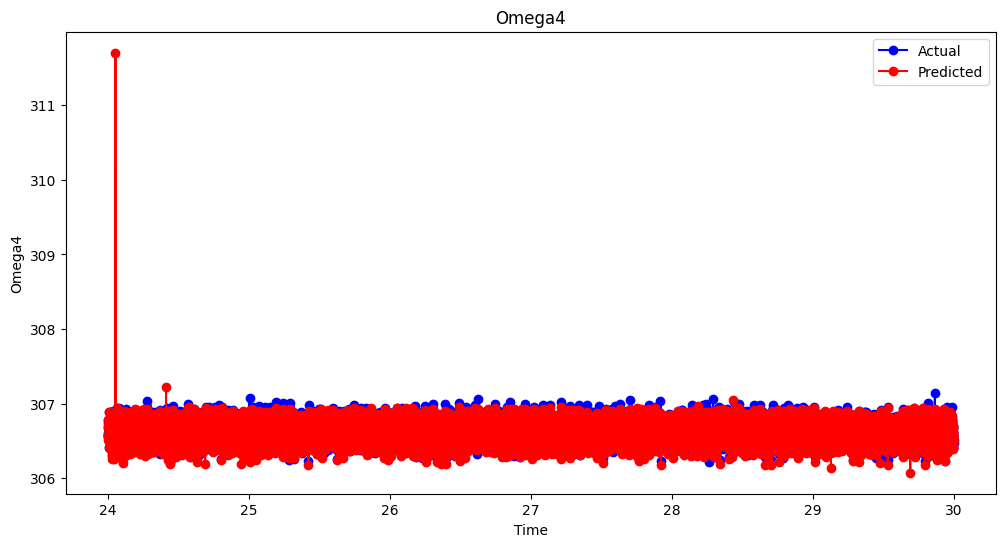

In [140]:
print('GRU predictions')
plot_targets(y_test,df_y_pred_GRU,'Omega4')

print()

print('Linear Regression predictions')
plot_targets(y_test,df_y_pred_LR,'Omega4')